In [ ]:
pip install spotipy

     |████████████████████████████████| 138 kB 5.0 MB/s 
     |████████████████████████████████| 62 kB 866 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import tree

In [ ]:
CLIENT_ID     = '3ac63637251243ab9871628ef62018b4'
CLIENT_SECRET = 'b27c42db70e046b0b98ad6cfdde08a12'
PLAYLIST_ID   = '37i9dQZF1DWYJ5kmTbkZiz' # Spotify playlist id

# API Login
client_credentials_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

# Obtain Tracks of Playlist
tracks = sp.user_playlist_tracks(user='spotify', playlist_id=PLAYLIST_ID)
tracks_uri_list = [x['track']['uri'] for x in tracks['items']]

# Obtain Features of Tracks
features = []
for i in tracks_uri_list:
    features = features + sp.audio_features(i)

# Create Feature Dataframe
df = pd.DataFrame(features)

In [ ]:
tracks_df = pd.DataFrame()

# Get Track Name
tracks_df['track_name'] = [x['track']['name'] for x in tracks['items']]

# Get Artists Names
artists_names = []
for x in tracks['items']:
    artists_names.append(', '.join(y['name'] for y in x['track']['artists']))
    
tracks_df['artists_names'] = artists_names

DATA PREPROCESSING

Since there were no missing data in each feature, no rows will be dropped. However, since there are some features that are not value adding to the modeling, those will be dropped. The features that will be droppped are: ```analysis_url```, ```id```, ```track_href```, ```type``` and ```uri```.

In [ ]:
# Define Features to Drop
dropCols = ['analysis_url', 'id', 'track_href', 'type', 'uri']

# Drop Features
df.drop(dropCols, axis=1, inplace=True)

# Ensure Features are dropped
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [ ]:
#Split Data (Independent Variables [X] & Dependent Variable [y])

dependentVar = 'danceability' # Goal to predict danceability!

X = df.loc[:, df.columns != dependentVar] #Independent
y = df[dependentVar].values #Dependent

In [ ]:
features = X.columns.tolist() #features that we will use to predict danceability
print(features)

['energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [ ]:
#Feature Scaling
sc = StandardScaler()
X  = sc.fit_transform(X) #scaled all the features so that they are in the same range

Split Data (Train & Test)

Since the dataset size is 50 rows, we will dedicate 40 for training and 10 for testing. This means our testing size will be 0.20 to have 20% of 50 to be in testing and 80% of 50 to be in training.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state=1234)

## <font color='orange'> DATA MODELING - PART 2 - SUPERVISED LEARNING  </font>

In [ ]:
df_Model   = pd.DataFrame(columns = ['Model Name', 'RMSE Score']) # Lower the RMSE the better
dict_Model = {}

In [ ]:
#Building a model on TRAINING Data
dtModel = DecisionTreeRegressor()
dtModel.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
#Verify model on validation(testing) set
y_pred = dtModel.predict(X_val) #using the DT Regressor, predict the y-values of the x_vals testing set

print(y_val) #actual y-values of the testing/validation set
print(y_pred) #predicted y-values of the testing/validation set 

[0.649 0.617 0.778 0.751 0.378 0.856 0.749 0.655 0.865 0.835]
[0.664 0.782 0.645 0.509 0.758 0.758 0.4   0.664 0.781 0.704]


In [ ]:
rmse             = round((mean_squared_error(y_val, y_pred)**(1/2)), 2)
name             = 'DT Base'
df_Model         = df_Model.append({'Model Name':name, 'RMSE Score':rmse}, ignore_index=True)
dict_Model[name] = dtModel

param_grid_dt = {     
    'criterion': ['mse', 'mae'],  
    'splitter': ['best', 'random'],      
    'max_depth': [None, 2, 4, 6, 8, 10]
}

dtModel_grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid_dt, 
                            scoring='neg_root_mean_squared_error', verbose=1, cv=10, n_jobs=-1)
dtModel_grid.fit(X_train, y_train)

print(dtModel_grid.best_estimator_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
DecisionTreeRegressor(criterion='mse', max_depth=4, splitter='random')


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [ ]:
y_pred = dtModel_grid.predict(X_val)

print(y_val)
print(y_pred)

[0.649 0.617 0.778 0.751 0.378 0.856 0.749 0.655 0.865 0.835]
[0.65745455 0.73291667 0.8072     0.65745455 0.65745455 0.73291667
 0.73291667 0.65745455 0.65745455 0.73291667]


In [ ]:
rmse             = round((mean_squared_error(y_val, y_pred)**(1/2)), 2)
name             = 'DT Tune'
df_Model         = df_Model.append({'Model Name':name, 'RMSE Score':rmse}, ignore_index=True)
dict_Model[name] = dtModel_grid


In [ ]:
text_representation = tree.export_text(dtModel_grid.best_estimator_)
print(text_representation)

|--- feature_11 <= -0.35
|   |--- value: [0.40]
|--- feature_11 >  -0.35
|   |--- feature_10 <= -0.50
|   |   |--- feature_7 <= 3.48
|   |   |   |--- feature_9 <= 0.05
|   |   |   |   |--- value: [0.74]
|   |   |   |--- feature_9 >  0.05
|   |   |   |   |--- value: [0.81]
|   |   |--- feature_7 >  3.48
|   |   |   |--- value: [0.45]
|   |--- feature_10 >  -0.50
|   |   |--- feature_5 <= 2.04
|   |   |   |--- feature_9 <= 0.13
|   |   |   |   |--- value: [0.73]
|   |   |   |--- feature_9 >  0.13
|   |   |   |   |--- value: [0.66]
|   |   |--- feature_5 >  2.04
|   |   |   |--- value: [0.42]



[Text(148.8, 195.696, 'X[11] <= -0.353\nmse = 0.014\nsamples = 40\nvalue = 0.699'),
 Text(111.60000000000001, 152.208, 'mse = 0.0\nsamples = 1\nvalue = 0.4'),
 Text(186.0, 152.208, 'X[10] <= -0.5\nmse = 0.012\nsamples = 39\nvalue = 0.707'),
 Text(111.60000000000001, 108.72, 'X[7] <= 3.483\nmse = 0.01\nsamples = 15\nvalue = 0.741'),
 Text(74.4, 65.232, 'X[9] <= 0.053\nmse = 0.004\nsamples = 14\nvalue = 0.762'),
 Text(37.2, 21.744, 'mse = 0.002\nsamples = 9\nvalue = 0.737'),
 Text(111.60000000000001, 21.744, 'mse = 0.006\nsamples = 5\nvalue = 0.807'),
 Text(148.8, 65.232, 'mse = 0.0\nsamples = 1\nvalue = 0.448'),
 Text(260.40000000000003, 108.72, 'X[5] <= 2.044\nmse = 0.012\nsamples = 24\nvalue = 0.685'),
 Text(223.20000000000002, 65.232, 'X[9] <= 0.129\nmse = 0.009\nsamples = 23\nvalue = 0.697'),
 Text(186.0, 21.744, 'mse = 0.008\nsamples = 12\nvalue = 0.733'),
 Text(260.40000000000003, 21.744, 'mse = 0.008\nsamples = 11\nvalue = 0.657'),
 Text(297.6, 65.232, 'mse = 0.0\nsamples = 1\nva

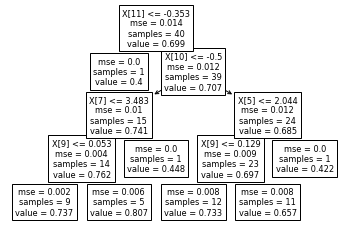

In [ ]:
tree.plot_tree(dtModel_grid.best_estimator_)

### <font color='pink'> K-NEAREST NEIGHBORS (KNN) </font>

In [ ]:
#Build a model on TRAINING data
kNNModel = KNeighborsRegressor()
kNNModel.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
#Verify Model on Validation Data
y_pred = kNNModel.predict(X_val)

print(y_val)
print(y_pred)

[0.649 0.617 0.778 0.751 0.378 0.856 0.749 0.655 0.865 0.835]
[0.648  0.7538 0.7456 0.6412 0.7054 0.6968 0.6588 0.648  0.7186 0.6996]


In [ ]:
from sklearn.metrics import mean_squared_error

rmse             = round((mean_squared_error(y_val, y_pred)**(1/2)), 2)
name             = 'KNN Base'
df_Model         = df_Model.append({'Model Name':name, 'RMSE Score':rmse}, ignore_index=True)
dict_Model[name] = kNNModel

param_grid_knn = {
    'n_neighbors': [2, 5, 10, 15],                                   
    'algorithm': ['brute', 'auto'],          
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
}

kNNModel_grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_knn, 
                             scoring='neg_root_mean_squared_error', verbose=1, cv=10, n_jobs=-1)
kNNModel_grid.fit(X_train, y_train)

print(kNNModel_grid.best_estimator_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
KNeighborsRegressor(algorithm='brute', metric='manhattan', n_neighbors=15)


In [ ]:
rmse             = round((mean_squared_error(y_val, y_pred)**(1/2)), 2)
name             = 'KNN Tune'
df_Model         = df_Model.append({'Model Name':name, 'RMSE Score':rmse}, ignore_index=True)
dict_Model[name] = kNNModel_grid